***Semantic Similarity on SNLI (Stanford Natural Language Inference) corpus using BERT(Pooled) model***


**Installing and importing libraries**

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
!pip install transformers
import transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 61.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 37.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 106.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 95.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 36.4 MB/s eta 0:00:00


**Configuration**

In [3]:
max_length = 128  # Maximum length of input sentence to the model.
batch_size = 32
epochs = 5

# Labels in our dataset.
labels = ["contradiction", "entailment", "neutral"]

**Load the Data**

In [4]:
!curl -LO https://raw.githubusercontent.com/MohamadMerchant/SNLI/master/data.tar.gz
!tar -xvzf data.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 11.1M  100 11.1M    0     0  12.3M      0 --:--:-- --:--:-- --:--:-- 12.3M
SNLI_Corpus/
SNLI_Corpus/snli_1.0_dev.csv
SNLI_Corpus/snli_1.0_train.csv
SNLI_Corpus/snli_1.0_test.csv


*To check whether GPU is available or not.*

In [5]:
import torch
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


**Reading the data**

In [6]:
# There are more than 550k samples in total; we will use 100k for this example.
train_df = pd.read_csv("/content/SNLI_Corpus/snli_1.0_train.csv", nrows=50000)
valid_df = pd.read_csv("/content/SNLI_Corpus/snli_1.0_dev.csv")
test_df = pd.read_csv("/content/SNLI_Corpus/snli_1.0_test.csv")

# Shape of the data
print(f"Total train samples : {train_df.shape[0]}")
print(f"Total validation samples: {valid_df.shape[0]}")
print(f"Total test samples: {valid_df.shape[0]}")


Total train samples : 50000
Total validation samples: 10000
Total test samples: 10000


Dataset Overview:

*   sentence1: The premise caption that was supplied to the author of the pair.

*   sentence2: The hypothesis caption that was written by the author of the pair.

*   similarity: This is the label chosen by the majority of annotators.

Where no majority exists, the label "-" is used (we will skip such samples here).

Here are the "similarity" label values in our dataset:


*   Contradiction: The sentences share no
similarity.
*   Entailment: The sentences have similar meaning.
* Neutral: The sentences are neutral.

Let's look at one sample from the dataset:

In [7]:
print(f"Sentence1: {train_df.loc[2, 'sentence1']}")
print(f"Sentence2: {train_df.loc[2, 'sentence2']}")
print(f"Similarity: {train_df.loc[2, 'similarity']}")


Sentence1: A person on a horse jumps over a broken down airplane.
Sentence2: A person is outdoors, on a horse.
Similarity: entailment


**Preprocessing**

In [8]:
# We have some NaN entries in our train data, we will simply drop them.
print("Number of missing values")
print(train_df.isnull().sum())
train_df.dropna(axis=0, inplace=True)

Number of missing values
similarity    0
sentence1     0
sentence2     0
dtype: int64


Distribution of training and validation target

In [9]:
print("Train Target Distribution")
print(train_df.similarity.value_counts())

Train Target Distribution
entailment       16679
contradiction    16647
neutral          16621
-                   53
Name: similarity, dtype: int64


In [10]:
print("Validation Target Distribution")
print(valid_df.similarity.value_counts())

Validation Target Distribution
entailment       3329
contradiction    3278
neutral          3235
-                 158
Name: similarity, dtype: int64


The value "-" appears as part of our training and validation targets. We will skip these samples.


In [11]:
train_df = (
    train_df[train_df.similarity != "-"]
    .sample(frac=1.0, random_state=42)
    .reset_index(drop=True)
)
valid_df = (
    valid_df[valid_df.similarity != "-"]
    .sample(frac=1.0, random_state=42)
    .reset_index(drop=True)
)

One-hot encoding performed for creating labels for a classification problems


*   If the value x is "contradiction," it assigns the label 0.
*   If the value x is "entailment," it assigns the label 1.
*   If the value x is neither "contradiction" nor "entailment," it assigns the label 2 (which is typically used for cases like "neutral" or "other").

In [12]:
train_df["label"] = train_df["similarity"].apply(
    lambda x: 0 if x == "contradiction" else 1 if x == "entailment" else 2
)
y_train = tf.keras.utils.to_categorical(train_df.label, num_classes=3)

valid_df["label"] = valid_df["similarity"].apply(
    lambda x: 0 if x == "contradiction" else 1 if x == "entailment" else 2
)
y_val = tf.keras.utils.to_categorical(valid_df.label, num_classes=3)

test_df["label"] = test_df["similarity"].apply(
    lambda x: 0 if x == "contradiction" else 1 if x == "entailment" else 2
)
y_test = tf.keras.utils.to_categorical(test_df.label, num_classes=3)

***Keras Custom Data Generator for Semantic Similarity***

In [13]:
class BertSemanticDataGenerator(tf.keras.utils.Sequence):
    """Generates batches of data.

    Args:
        sentence_pairs: Array of premise and hypothesis input sentences.
        labels: Array of labels.
        batch_size: Integer batch size.
        shuffle: boolean, whether to shuffle the data.
        include_targets: boolean, whether to incude the labels.

    Returns:
        Tuples `([input_ids, attention_mask, `token_type_ids], labels)`
        (or just `[input_ids, attention_mask, `token_type_ids]`
         if `include_targets=False`)
    """

    def __init__(
        self,
        sentence_pairs,
        labels,
        batch_size=batch_size,
        shuffle=True,
        include_targets=True,
    ):
        self.sentence_pairs = sentence_pairs
        self.labels = labels
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.include_targets = include_targets
        # Load our BERT Tokenizer to encode the text.
        # We will use base-base-uncased pretrained model.
        self.tokenizer = transformers.BertTokenizer.from_pretrained(
            "bert-base-uncased", do_lower_case=True
        )
        self.indexes = np.arange(len(self.sentence_pairs))
        self.on_epoch_end()

    def __len__(self):
        # Denotes the number of batches per epoch.
        return len(self.sentence_pairs) // self.batch_size

    def __getitem__(self, idx):
        # Retrieves the batch of index.
        indexes = self.indexes[idx * self.batch_size : (idx + 1) * self.batch_size]
        sentence_pairs = self.sentence_pairs[indexes]

        # With BERT tokenizer's batch_encode_plus batch of both the sentences are
        # encoded together and separated by [SEP] token.
        encoded = self.tokenizer.batch_encode_plus(
            sentence_pairs.tolist(),
            add_special_tokens=True,
            max_length=max_length,
            return_attention_mask=True,
            return_token_type_ids=True,
            pad_to_max_length=True,
            return_tensors="tf",
        )

        # Convert batch of encoded features to numpy array.
        input_ids = np.array(encoded["input_ids"], dtype="int32")
        attention_masks = np.array(encoded["attention_mask"], dtype="int32")
        token_type_ids = np.array(encoded["token_type_ids"], dtype="int32")

        # Set to true if data generator is used for training/validation.
        if self.include_targets:
            labels = np.array(self.labels[indexes], dtype="int32")
            return [input_ids, attention_masks, token_type_ids], labels
        else:
            return [input_ids, attention_masks, token_type_ids]

    def on_epoch_end(self):
        # Shuffle indexes after each epoch if shuffle is set to True.
        if self.shuffle:
            np.random.RandomState(42).shuffle(self.indexes)


**Build the model**

In [19]:
# Create the model under a distribution strategy scope.
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    # Encoded token ids from BERT tokenizer.
    input_ids = tf.keras.layers.Input(
        shape=(max_length,), dtype=tf.int32, name="input_ids"
    )
    # Attention masks indicates to the model which tokens should be attended to.
    attention_masks = tf.keras.layers.Input(
        shape=(max_length,), dtype=tf.int32, name="attention_masks"
    )
    # Token type ids are binary masks identifying different sequences in the model.
    token_type_ids = tf.keras.layers.Input(
        shape=(max_length,), dtype=tf.int32, name="token_type_ids"
    )
    # Loading pretrained BERT model.
    bert_model = transformers.TFBertModel.from_pretrained("bert-base-uncased")
    # Freeze the BERT model to reuse the pretrained features without modifying them.
    bert_model.trainable = False

    bert_output = bert_model.bert(
        input_ids, attention_mask=attention_masks, token_type_ids=token_type_ids
    )
    sequence_output = bert_output.last_hidden_state
    pooled_output = bert_output.pooler_output
    # Add trainable layers on top of frozen layers to adapt the pretrained features on the new data.
    bi_lstm = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(64, return_sequences=True)
    )(sequence_output)
    # Applying hybrid pooling approach to bi_lstm sequence output.
    avg_pool = tf.keras.layers.GlobalAveragePooling1D()(bi_lstm)
    max_pool = tf.keras.layers.GlobalMaxPooling1D()(bi_lstm)
    concat = tf.keras.layers.concatenate([avg_pool, max_pool])
    dropout = tf.keras.layers.Dropout(0.3)(concat)
    output = tf.keras.layers.Dense(3, activation="softmax")(dropout)
    model = tf.keras.models.Model(
        inputs=[input_ids, attention_masks, token_type_ids], outputs=output
    )

    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss="categorical_crossentropy",
        metrics=["acc"],
    )


print(f"Strategy: {strategy}")
model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Strategy: <tensorflow.python.distribute.mirrored_strategy.MirroredStrategy object at 0x7c0e6cb6ace0>
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 128)]                0         []                            
                                                                                                  
 attention_masks (InputLaye  [(None, 128)]                0         []                            
 r)                                                                                               
                                                                                                  
 token_type_ids (InputLayer  [(None, 128)]                0         []                            
 )                                                                                        

In [20]:
# Unfreeze the bert_model.
bert_model.trainable = True
# Recompile the model to make the change effective.
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 128)]                0         []                            
                                                                                                  
 attention_masks (InputLaye  [(None, 128)]                0         []                            
 r)                                                                                               
                                                                                                  
 token_type_ids (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                            

Create train and validation data generators


In [21]:
train_data = BertSemanticDataGenerator(
    train_df[["sentence1", "sentence2"]].values.astype("str"),
    y_train,
    batch_size=batch_size,
    shuffle=True,
)
valid_data = BertSemanticDataGenerator(
    valid_df[["sentence1", "sentence2"]].values.astype("str"),
    y_val,
    batch_size=batch_size,
    shuffle=False,
)

**Train the BERT(Pooled) model**

In [22]:
history = model.fit(
    train_data,
    validation_data=valid_data,
    epochs=epochs,
    use_multiprocessing=True,
    workers=-1,
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Epoch 1/5


  49/1560 [..............................] - ETA: 19:21 - loss: 1.1252 - accuracy: 0.3846

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 118/1560 [=>............................] - ETA: 18:45 - loss: 1.0592 - accuracy: 0.4378

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 182/1560 [==>...........................] - ETA: 18:05 - loss: 0.9831 - accuracy: 0.5022

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 194/1560 [==>...........................] - ETA: 17:57 - loss: 0.9683 - accuracy: 0.5135

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 251/1560 [===>..........................] - ETA: 17:19 - loss: 0.9172 - accuracy: 0.5524

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 290/1560 [====>.........................] - ETA: 16:51 - loss: 0.8852 - accuracy: 0.5752

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 346/1560 [=====>........................] - ETA: 16:11 - loss: 0.8535 - accuracy: 0.5957

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 350/1560 [=====>........................] - ETA: 16:08 - loss: 0.8508 - accuracy: 0.5978

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 421/1560 [=======>......................] - ETA: 15:15 - loss: 0.8139 - accuracy: 0.6226

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 456/1560 [=======>......................] - ETA: 14:48 - loss: 0.8023 - accuracy: 0.6306

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 536/1560 [=========>....................] - ETA: 13:45 - loss: 0.7730 - accuracy: 0.6487

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 709/1560 [============>.................] - ETA: 11:28 - loss: 0.7312 - accuracy: 0.6759

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 751/1560 [=============>................] - ETA: 10:55 - loss: 0.7220 - accuracy: 0.6816

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 811/1560 [==============>...............] - ETA: 10:06 - loss: 0.7078 - accuracy: 0.6895

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 825/1560 [==============>...............] - ETA: 9:55 - loss: 0.7047 - accuracy: 0.6916

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 888/1560 [================>.............] - ETA: 9:04 - loss: 0.6940 - accuracy: 0.6982

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 951/1560 [=================>............] - ETA: 8:14 - loss: 0.6874 - accuracy: 0.7026

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1121/1560 [====================>.........] - ETA: 5:56 - loss: 0.6646 - accuracy: 0.7166

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1159/1560 [=====================>........] - ETA: 5:25 - loss: 0.6594 - accuracy: 0.7193

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1210/1560 [======================>.......] - ETA: 4:44 - loss: 0.6548 - accuracy: 0.7223

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1230/1560 [======================>.......] - ETA: 4:28 - loss: 0.6525 - accuracy: 0.7235

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1260/1560 [=======================>......] - ETA: 4:03 - loss: 0.6499 - accuracy: 0.7250

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1267/1560 [=======================>......] - ETA: 3:58 - loss: 0.6493 - accuracy: 0.7255

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1364/1560 [=========================>....] - ETA: 2:39 - loss: 0.6398 - accuracy: 0.7301

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1382/1560 [=========================>....] - ETA: 2:24 - loss: 0.6385 - accuracy: 0.7308

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1401/1560 [=========================>....] - ETA: 2:09 - loss: 0.6365 - accuracy: 0.7320

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1498/1560 [===========================>..] - ETA: 50s - loss: 0.6288 - accuracy: 0.7364

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1531/1560 [============================>.] - ETA: 23s - loss: 0.6263 - accuracy: 0.7378

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1560/1560 [==============================] - ETA: 0s - loss: 0.6244 - accuracy: 0.7387

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will alwa

1560/1560 [==============================] - 1407s 872ms/step - loss: 0.6244 - accuracy: 0.7387 - val_loss: 0.4637 - val_accuracy: 0.8207
Epoch 2/5
  13/1560 [..............................] - ETA: 21:02 - loss: 0.4543 - accuracy: 0.8101

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  28/1560 [..............................] - ETA: 20:49 - loss: 0.4618 - accuracy: 0.8125

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 128/1560 [=>............................] - ETA: 19:31 - loss: 0.4332 - accuracy: 0.8296

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 264/1560 [====>.........................] - ETA: 17:40 - loss: 0.4416 - accuracy: 0.8313

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 273/1560 [====>.........................] - ETA: 17:32 - loss: 0.4422 - accuracy: 0.8317

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 312/1560 [=====>........................] - ETA: 17:01 - loss: 0.4444 - accuracy: 0.8316

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 329/1560 [=====>........................] - ETA: 16:47 - loss: 0.4464 - accuracy: 0.8312

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 352/1560 [=====>........................] - ETA: 16:28 - loss: 0.4443 - accuracy: 0.8321

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 374/1560 [======>.......................] - ETA: 16:10 - loss: 0.4437 - accuracy: 0.8327

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 406/1560 [======>.......................] - ETA: 15:44 - loss: 0.4420 - accuracy: 0.8336

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 420/1560 [=======>......................] - ETA: 15:32 - loss: 0.4418 - accuracy: 0.8341

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 479/1560 [========>.....................] - ETA: 14:44 - loss: 0.4435 - accuracy: 0.8334

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 498/1560 [========>.....................] - ETA: 14:29 - loss: 0.4442 - accuracy: 0.8333

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 503/1560 [========>.....................] - ETA: 14:25 - loss: 0.4447 - accuracy: 0.8331

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 524/1560 [=========>....................] - ETA: 14:08 - loss: 0.4454 - accuracy: 0.8324

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 599/1560 [==========>...................] - ETA: 13:06 - loss: 0.4431 - accuracy: 0.8329

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 631/1560 [===========>..................] - ETA: 12:40 - loss: 0.4426 - accuracy: 0.8329

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 699/1560 [============>.................] - ETA: 11:44 - loss: 0.4391 - accuracy: 0.8345

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 851/1560 [===============>..............] - ETA: 9:40 - loss: 0.4413 - accuracy: 0.8331

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 894/1560 [================>.............] - ETA: 9:05 - loss: 0.4407 - accuracy: 0.8337

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 895/1560 [================>.............] - ETA: 9:04 - loss: 0.4406 - accuracy: 0.8337

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 940/1560 [=================>............] - ETA: 8:27 - loss: 0.4392 - accuracy: 0.8336

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1098/1560 [====================>.........] - ETA: 6:17 - loss: 0.4394 - accuracy: 0.8326

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1227/1560 [======================>.......] - ETA: 4:32 - loss: 0.4370 - accuracy: 0.8339

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1330/1560 [========================>.....] - ETA: 3:08 - loss: 0.4358 - accuracy: 0.8340

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1385/1560 [=========================>....] - ETA: 2:23 - loss: 0.4351 - accuracy: 0.8340

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1472/1560 [===========================>..] - ETA: 1:11 - loss: 0.4338 - accuracy: 0.8349

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1505/1560 [===========================>..] - ETA: 44s - loss: 0.4337 - accuracy: 0.8350

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1560/1560 [==============================] - ETA: 0s - loss: 0.4329 - accuracy: 0.8357

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1560/1560 [==============================] - 1362s 873ms/step - loss: 0.4329 - accuracy: 0.8357 - val_loss: 0.4079 - val_accuracy: 0.8450
Epoch 3/5
   5/1560 [..............................] - ETA: 21:16 - loss: 0.3282 - accuracy: 0.8687

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  21/1560 [..............................] - ETA: 21:01 - loss: 0.3114 - accuracy: 0.8854

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 143/1560 [=>............................] - ETA: 19:20 - loss: 0.3327 - accuracy: 0.8770

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 200/1560 [==>...........................] - ETA: 18:33 - loss: 0.3281 - accuracy: 0.8792

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 306/1560 [====>.........................] - ETA: 17:05 - loss: 0.3288 - accuracy: 0.8794

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 315/1560 [=====>........................] - ETA: 16:58 - loss: 0.3282 - accuracy: 0.8796

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 321/1560 [=====>........................] - ETA: 16:53 - loss: 0.3297 - accuracy: 0.8791

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 330/1560 [=====>........................] - ETA: 16:46 - loss: 0.3292 - accuracy: 0.8797

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 395/1560 [======>.......................] - ETA: 15:52 - loss: 0.3288 - accuracy: 0.8797

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 412/1560 [======>.......................] - ETA: 15:38 - loss: 0.3315 - accuracy: 0.8784

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 509/1560 [========>.....................] - ETA: 14:19 - loss: 0.3338 - accuracy: 0.8758

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 662/1560 [===========>..................] - ETA: 12:14 - loss: 0.3351 - accuracy: 0.8753

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 695/1560 [============>.................] - ETA: 11:47 - loss: 0.3327 - accuracy: 0.8763

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 746/1560 [=============>................] - ETA: 11:05 - loss: 0.3317 - accuracy: 0.8773

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 765/1560 [=============>................] - ETA: 10:49 - loss: 0.3321 - accuracy: 0.8770

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 781/1560 [==============>...............] - ETA: 10:36 - loss: 0.3333 - accuracy: 0.8763

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 921/1560 [================>.............] - ETA: 8:42 - loss: 0.3350 - accuracy: 0.8755

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 937/1560 [=================>............] - ETA: 8:29 - loss: 0.3346 - accuracy: 0.8760

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 993/1560 [==================>...........] - ETA: 7:43 - loss: 0.3350 - accuracy: 0.8757

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1033/1560 [==================>...........] - ETA: 7:10 - loss: 0.3349 - accuracy: 0.8760

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1073/1560 [===================>..........] - ETA: 6:37 - loss: 0.3352 - accuracy: 0.8756

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1083/1560 [===================>..........] - ETA: 6:29 - loss: 0.3356 - accuracy: 0.8755

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1311/1560 [========================>.....] - ETA: 3:23 - loss: 0.3354 - accuracy: 0.8761

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1352/1560 [=========================>....] - ETA: 2:49 - loss: 0.3351 - accuracy: 0.8762

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1383/1560 [=========================>....] - ETA: 2:24 - loss: 0.3361 - accuracy: 0.8759

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1463/1560 [===========================>..] - ETA: 1:19 - loss: 0.3364 - accuracy: 0.8759

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1488/1560 [===========================>..] - ETA: 58s - loss: 0.3365 - accuracy: 0.8761

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1494/1560 [===========================>..] - ETA: 53s - loss: 0.3366 - accuracy: 0.8760

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1560/1560 [==============================] - ETA: 0s - loss: 0.3363 - accuracy: 0.8763

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1560/1560 [==============================] - 1360s 872ms/step - loss: 0.3363 - accuracy: 0.8763 - val_loss: 0.4065 - val_accuracy: 0.8528
Epoch 4/5
   6/1560 [..............................] - ETA: 20:46 - loss: 0.2542 - accuracy: 0.9271

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 139/1560 [=>............................] - ETA: 19:21 - loss: 0.2529 - accuracy: 0.9134

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 146/1560 [=>............................] - ETA: 19:16 - loss: 0.2527 - accuracy: 0.9137

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 229/1560 [===>..........................] - ETA: 18:07 - loss: 0.2515 - accuracy: 0.9116

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 254/1560 [===>..........................] - ETA: 17:46 - loss: 0.2530 - accuracy: 0.9110

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 276/1560 [====>.........................] - ETA: 17:28 - loss: 0.2527 - accuracy: 0.9107

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 325/1560 [=====>........................] - ETA: 16:48 - loss: 0.2535 - accuracy: 0.9106

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 366/1560 [======>.......................] - ETA: 16:14 - loss: 0.2594 - accuracy: 0.9082

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 433/1560 [=======>......................] - ETA: 15:20 - loss: 0.2565 - accuracy: 0.9092

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 496/1560 [========>.....................] - ETA: 14:28 - loss: 0.2567 - accuracy: 0.9095

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 550/1560 [=========>....................] - ETA: 13:44 - loss: 0.2560 - accuracy: 0.9087

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 578/1560 [==========>...................] - ETA: 13:21 - loss: 0.2558 - accuracy: 0.9086

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 599/1560 [==========>...................] - ETA: 13:04 - loss: 0.2545 - accuracy: 0.9092

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 615/1560 [==========>...................] - ETA: 12:51 - loss: 0.2563 - accuracy: 0.9085

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 650/1560 [===========>..................] - ETA: 12:22 - loss: 0.2576 - accuracy: 0.9082

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 819/1560 [==============>...............] - ETA: 10:04 - loss: 0.2560 - accuracy: 0.9088

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 844/1560 [===============>..............] - ETA: 9:44 - loss: 0.2551 - accuracy: 0.9092

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 878/1560 [===============>..............] - ETA: 9:16 - loss: 0.2551 - accuracy: 0.9089

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 902/1560 [================>.............] - ETA: 8:56 - loss: 0.2553 - accuracy: 0.9090

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 916/1560 [================>.............] - ETA: 8:45 - loss: 0.2558 - accuracy: 0.9088

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 960/1560 [=================>............] - ETA: 8:09 - loss: 0.2569 - accuracy: 0.9082

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1107/1560 [====================>.........] - ETA: 6:09 - loss: 0.2571 - accuracy: 0.9084

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1140/1560 [====================>.........] - ETA: 5:42 - loss: 0.2572 - accuracy: 0.9083

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1250/1560 [=======================>......] - ETA: 4:12 - loss: 0.2578 - accuracy: 0.9082

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1298/1560 [=======================>......] - ETA: 3:33 - loss: 0.2584 - accuracy: 0.9079

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1428/1560 [==========================>...] - ETA: 1:47 - loss: 0.2584 - accuracy: 0.9078

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1477/1560 [===========================>..] - ETA: 1:07 - loss: 0.2588 - accuracy: 0.9079

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1488/1560 [===========================>..] - ETA: 58s - loss: 0.2588 - accuracy: 0.9078

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1560/1560 [==============================] - ETA: 0s - loss: 0.2593 - accuracy: 0.9076

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1560/1560 [==============================] - 1359s 871ms/step - loss: 0.2593 - accuracy: 0.9076 - val_loss: 0.4319 - val_accuracy: 0.8522
Epoch 5/5
  71/1560 [>.............................] - ETA: 20:16 - loss: 0.2087 - accuracy: 0.9327

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 163/1560 [==>...........................] - ETA: 18:59 - loss: 0.1982 - accuracy: 0.9342

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 164/1560 [==>...........................] - ETA: 18:59 - loss: 0.1983 - accuracy: 0.9341

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 212/1560 [===>..........................] - ETA: 18:20 - loss: 0.1969 - accuracy: 0.9348

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 442/1560 [=======>......................] - ETA: 15:13 - loss: 0.1952 - accuracy: 0.9340

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 453/1560 [=======>......................] - ETA: 15:04 - loss: 0.1943 - accuracy: 0.9343

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 486/1560 [========>.....................] - ETA: 14:37 - loss: 0.1944 - accuracy: 0.9340

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 501/1560 [========>.....................] - ETA: 14:25 - loss: 0.1942 - accuracy: 0.9341

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 605/1560 [==========>...................] - ETA: 13:00 - loss: 0.1950 - accuracy: 0.9339

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 613/1560 [==========>...................] - ETA: 12:54 - loss: 0.1951 - accuracy: 0.9339

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 712/1560 [============>.................] - ETA: 11:33 - loss: 0.1957 - accuracy: 0.9340

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 718/1560 [============>.................] - ETA: 11:28 - loss: 0.1963 - accuracy: 0.9339

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 761/1560 [=============>................] - ETA: 10:53 - loss: 0.1969 - accuracy: 0.9337

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 773/1560 [=============>................] - ETA: 10:43 - loss: 0.1968 - accuracy: 0.9338

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 925/1560 [================>.............] - ETA: 8:39 - loss: 0.1953 - accuracy: 0.9343

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 933/1560 [================>.............] - ETA: 8:32 - loss: 0.1950 - accuracy: 0.9345

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 998/1560 [==================>...........] - ETA: 7:39 - loss: 0.1969 - accuracy: 0.9336

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1025/1560 [==================>...........] - ETA: 7:17 - loss: 0.1966 - accuracy: 0.9340

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1035/1560 [==================>...........] - ETA: 7:09 - loss: 0.1958 - accuracy: 0.9343

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1054/1560 [===================>..........] - ETA: 6:53 - loss: 0.1957 - accuracy: 0.9343

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1085/1560 [===================>..........] - ETA: 6:28 - loss: 0.1951 - accuracy: 0.9346

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1107/1560 [====================>.........] - ETA: 6:10 - loss: 0.1949 - accuracy: 0.9346

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1162/1560 [=====================>........] - ETA: 5:25 - loss: 0.1949 - accuracy: 0.9345

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1179/1560 [=====================>........] - ETA: 5:11 - loss: 0.1953 - accuracy: 0.9344

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1265/1560 [=======================>......] - ETA: 4:01 - loss: 0.1963 - accuracy: 0.9339

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1304/1560 [========================>.....] - ETA: 3:29 - loss: 0.1966 - accuracy: 0.9336

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1327/1560 [========================>.....] - ETA: 3:10 - loss: 0.1965 - accuracy: 0.9338

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1451/1560 [==========================>...] - ETA: 1:29 - loss: 0.1959 - accuracy: 0.9338

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1560/1560 [==============================] - ETA: 0s - loss: 0.1957 - accuracy: 0.9338

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1560/1560 [==============================] - 1361s 873ms/step - loss: 0.1957 - accuracy: 0.9338 - val_loss: 0.4944 - val_accuracy: 0.8482


In [24]:
history.history

{'loss': [0.6244377493858337,
  0.4329190254211426,
  0.3362923264503479,
  0.25930777192115784,
  0.19567102193832397],
 'accuracy': [0.7387019395828247,
  0.8356570601463318,
  0.8763020634651184,
  0.9075520634651184,
  0.9338141083717346],
 'val_loss': [0.4636983871459961,
  0.40788576006889343,
  0.4065006971359253,
  0.43186572194099426,
  0.4944220781326294],
 'val_accuracy': [0.8207451105117798,
  0.8449714779853821,
  0.8528094291687012,
  0.8521987199783325,
  0.8482288122177124]}

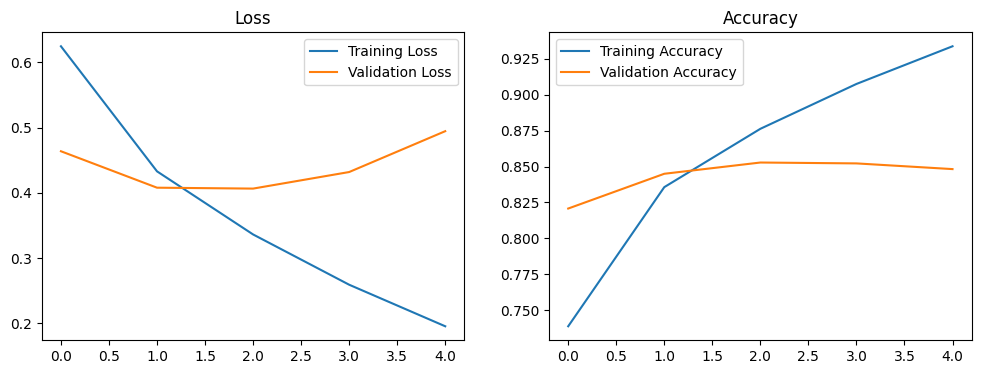

In [26]:
import matplotlib.pyplot as plt

# Plot loss and accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

plt.show()


**Evaluate model on the test set**

In [28]:
test_data = BertSemanticDataGenerator(
    test_df[["sentence1", "sentence2"]].values.astype("str"),
    y_test,
    batch_size=batch_size,
    shuffle=False,
)
model.evaluate(test_data, verbose=1)


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


 68/312 [=====>........................] - ETA: 1:11 - loss: 0.5274 - accuracy: 0.8382

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 81/312 [======>.......................] - ETA: 1:07 - loss: 0.5250 - accuracy: 0.8403

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


312/312 [==============================] - 90s 287ms/step - loss: 0.5092 - accuracy: 0.8407


[0.509203314781189, 0.840745210647583]

**Inference on custom sentences**

In [29]:
def check_similarity(sentence1, sentence2):
    sentence_pairs = np.array([[str(sentence1), str(sentence2)]])
    test_data = BertSemanticDataGenerator(
        sentence_pairs, labels=None, batch_size=1, shuffle=False, include_targets=False,
    )

    proba = model.predict(test_data[0])[0]
    idx = np.argmax(proba)
    proba = f"{proba[idx]: .2f}%"
    pred = labels[idx]
    return pred, proba


Check results on some example sentence pairs.

In [30]:
sentence1 = "Two women are observing something together."
sentence2 = "Two women are standing with their eyes closed."
check_similarity(sentence1, sentence2)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


1/1 [==============================] - 9s 9s/step


('contradiction', ' 0.97%')

In [31]:
sentence1 = "A smiling costumed woman is holding an umbrella"
sentence2 = "A happy woman in a fairy costume holds an umbrella"
check_similarity(sentence1, sentence2)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


1/1 [==============================] - 0s 155ms/step


('neutral', ' 0.92%')

In [32]:
sentence1 = "Cyberpunk is a cool game"
sentence2 = "i dont like cyberpunk"
check_similarity(sentence1, sentence2)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


1/1 [==============================] - 0s 154ms/step


('contradiction', ' 0.95%')

In [39]:
sentence1 = "The cat is sitting on a mat"
sentence2 = "A feline animal is on a rug"
check_similarity(sentence1, sentence2)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


1/1 [==============================] - 0s 259ms/step


('entailment', ' 0.98%')

In [34]:
sentence1 = "The sun is setting over a tranquil, coastal town."
sentence2 ="An evening view of a peaceful seaside village with the sun going down."
check_similarity(sentence1, sentence2)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


1/1 [==============================] - 0s 170ms/step


('contradiction', ' 0.71%')

In [41]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


**Save the trained model**

In [40]:
model.save("semantic_bert(pooled)_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


**Save the model to Google drive**

In [42]:
model_name = "semantic_bert(pooled)_model.h5"
path = F"/content/gdrive/My Drive/CoverPAge/{model_name}"

In [43]:
model.save(path)

**Load the model**

In [44]:
model = tf.keras.models.load_model(path)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 128)]                0         []                            
                                                                                                  
 attention_masks (InputLaye  [(None, 128)]                0         []                            
 r)                                                                                               
                                                                                                  
 token_type_ids (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                            